In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import plotly.graph_objects as go
import sklearn

In [3]:
X = np.load("../data/X.npy") # Shape: (num_sequences, 5, 24)

# Features:
# 0: aFRR_Net_Quantity_MW (Target)
# 1: mean_temp           (Condition)
# 2: mean_wind_speed     (Condition)
# 3: day_sin             (Condition)
# 4: day_cos             (Condition)

target = X[:, 0, :]
condition = X[:, 1:, :]

cond_tensor = torch.tensor(condition, dtype=torch.float32)
target_tensor = torch.tensor(target, dtype=torch.float32)

dataset = TensorDataset(cond_tensor, target_tensor)

cond_dim = 4 * 24
target_dim = 24
latent_dim = 16

n_total = len(dataset)
n_train = int(0.8 * n_total)
n_val = n_total - n_train
train_dataset, val_dataset = random_split(dataset, [n_train, n_val])

print(f"Total samples: {n_total}, Training samples: {n_train}, Validation samples: {n_val}")

train_loader = DataLoader(train_dataset, batch_size=2**8, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=2**8, shuffle=False)


""" plt.figure(figsize=(20, 6))
ax = sns.heatmap(target.T, cmap='coolwarm', cbar_kws={'label': 'Imbalance'}, xticklabels=50)
ax.set_xlabel("Day")
ax.set_ylabel("Hour")
plt.title("Heatmap of Imbalance")
plt.gca().invert_yaxis()
plt.show() """


Total samples: 640, Training samples: 512, Validation samples: 128


' plt.figure(figsize=(20, 6))\nax = sns.heatmap(target.T, cmap=\'coolwarm\', cbar_kws={\'label\': \'Imbalance\'}, xticklabels=50)\nax.set_xlabel("Day")\nax.set_ylabel("Hour")\nplt.title("Heatmap of Imbalance")\nplt.gca().invert_yaxis()\nplt.show() '

In [4]:
class MLPBlock(nn.Module):
    def __init__(self, input_dim, dropout_prob=0.1):
        super(MLPBlock, self).__init__()
        inner_dim = 4 * input_dim 
        self.layer_norm = nn.LayerNorm(input_dim)
        self.fc1 = nn.Linear(input_dim, inner_dim)
        self.fc2 = nn.Linear(inner_dim, input_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)
    
    def forward(self, x):
        residual = x
        x = self.layer_norm(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x + residual

In [5]:
class Encoder(nn.Module):
    def __init__(self, cond_dim, target_dim, latent_dim, mlp_blocks=2, hidden_dim=128, dropout_prob=0.1):
        super(Encoder, self).__init__()
        input_dim = cond_dim + target_dim
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.mlp = nn.Sequential(*[MLPBlock(hidden_dim, dropout_prob) for _ in range(mlp_blocks)])
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
    
    def forward(self, cond, target):
        batch_size = cond.shape[0]
        cond_flat = cond.view(batch_size, -1) # Flatten seq and feature dims
        target_flat = target.view(batch_size, -1) # Ensure target is also flat (batch, 24)

        x = torch.cat([cond_flat, target_flat], dim=1)
        x = self.input_layer(x)
        x = self.mlp(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    

In [6]:
class Decoder(nn.Module):
    def __init__(self, cond_dim, latent_dim, target_dim, mlp_blocks=2, hidden_dim=128, dropout_prob=0.1):
        super(Decoder, self).__init__()
        input_dim = cond_dim + latent_dim
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.mlp = nn.Sequential(*[MLPBlock(hidden_dim, dropout_prob) for _ in range(mlp_blocks)])
        self.output_layer = nn.Linear(hidden_dim, target_dim)
    
    def forward(self, cond, z):
        batch_size = cond.shape[0]
        cond_flat = cond.view(batch_size, -1) # Flatten seq and feature dims
        x = torch.cat([cond_flat, z], dim=1)
        x = self.input_layer(x)
        x = self.mlp(x)
        out = self.output_layer(x)
        return out

In [7]:
# 3, 192, 0.15
class CVAE(nn.Module):
    def __init__(self, cond_dim, target_dim, latent_dim, mlp_blocks=3, hidden_dim=192, dropout_prob=0.15):
        super(CVAE, self).__init__()
        self.encoder = Encoder(cond_dim, target_dim, latent_dim, mlp_blocks, hidden_dim, dropout_prob)
        self.decoder = Decoder(cond_dim, latent_dim, target_dim, mlp_blocks=2, hidden_dim=128, dropout_prob=0.1)
        self.mask_ratio = 0.2
    
    def reparameterize(self, mu, logvar):
        logvar = torch.clamp(logvar, min=-10, max=10)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, cond, target, apply_mask=True):
        if self.training and apply_mask:
            # Create and apply mask
            mask = torch.bernoulli(torch.ones_like(target) * (1 - self.mask_ratio))
            target_masked = target * mask
            target_noisy = target_masked + 0.02 * torch.randn_like(target_masked)
            mu, logvar = self.encoder(cond, target_noisy)
        else:
            mu, logvar = self.encoder(cond, target)
            
        z = self.reparameterize(mu, logvar)
        recon_target = self.decoder(cond, z)
        
        return recon_target, mu, logvar

In [8]:
def loss_function(recon_target, target, mu, logvar, kl_weight=1.0, min_kl=0.1, return_components=False):
    recon_loss = F.mse_loss(recon_target, target, reduction='mean')
    raw_kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Enforce minimum KL divergence
    kl_loss = torch.max(raw_kl_loss, torch.tensor(min_kl).to(raw_kl_loss.device))
    
    total_loss = recon_loss + 3.0 * kl_weight * kl_loss
    
    if return_components:
        return total_loss, recon_loss, raw_kl_loss
    return total_loss

In [9]:
def calculate_kl_weight(epoch, total_epochs, warmup_epochs, min_weight=0.0, max_weight=1.0, schedule_type='linear'):
    if schedule_type == 'linear':
        # Linear annealing from min_weight to max_weight
        return min_weight + (max_weight - min_weight) * min(1.0, epoch / warmup_epochs)
    
    elif schedule_type == 'sigmoid':
        # Sigmoid annealing for smoother transition
        if warmup_epochs > 0:
            ratio = epoch / warmup_epochs
            return min_weight + (max_weight - min_weight) * (1 / (1 + np.exp(-10 * (ratio - 0.5))))
        else:
            return max_weight
    
    elif schedule_type == 'cyclical':
        # Cyclical annealing with a cycle length of 2*warmup_epochs
        if warmup_epochs > 0:
            cycle_length = 2 * warmup_epochs
            cycle = (epoch % cycle_length) / cycle_length
            if cycle < 0.5:
                # Increasing part of the cycle
                return min_weight + (max_weight - min_weight) * (2 * cycle)
            else:
                # Keep at max for the second half of the cycle
                return max_weight
        else:
            return max_weight
    
    else:
        # Default to constant max weight
        return max_weight

In [10]:
def loss_function_masked(recon_target, target, mu, logvar, mask):
    mask_expanded = mask.unsqueeze(0)
    
    # Compute MSE loss only on masked elements
    mse_loss = ((recon_target - target) ** 2) * mask_expanded
    # Sum over all masked elements and normalize by the total number of missing entries
    mse_loss = mse_loss.sum() / mask.sum()
    
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return mse_loss + kl_loss

In [11]:
def pinball_loss(y_true, y_pred, quantile, masked=False, mask=None):
    error = y_true - y_pred
    loss_tensor = torch.where(error >= 0, quantile * error, (quantile - 1) * error)
    
    if masked:
        if mask is None:
            raise ValueError("Masked loss requested but no mask provided.")
        
        mask = mask.to(y_true.device).float()
        mask = mask.unsqueeze(0).expand_as(y_true)
        loss = (loss_tensor * mask).sum() / mask.sum()
    else:
        loss = torch.mean(loss_tensor)
    
    return loss


In [12]:
def crps_loss(y_true, samples):
    num_samples = samples.shape[0]
    y_true_expanded = y_true.unsqueeze(0).expand(num_samples, *y_true.shape)
    
    # First term: average absolute difference between each sample and the true value.
    term1 = torch.abs(samples - y_true_expanded).mean(dim=0)
    
    # Second term: average pairwise absolute differences among samples.
    # Compute pairwise differences along the sample axis.
    diff = torch.abs(samples.unsqueeze(0) - samples.unsqueeze(1))
    term2 = diff.mean(dim=(0, 1))  # shape: [batch, target_dim]
    
    # CRPS per instance and target dimension.
    crps = term1 - 0.5 * term2
    # Return the average CRPS over the batch and target dimensions.
    return crps.mean()

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CVAE(cond_dim, target_dim, latent_dim, mlp_blocks=3, hidden_dim=192, dropout_prob=0.15).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
#mask = mask.to(device)

In [14]:
num_epochs = 2**12
warmup_epochs = 1000  # Number of epochs for KL annealing
kl_annealing_schedule = 'cyclical'  # Options: 'linear', 'sigmoid', 'cyclical'

# Lists to track metrics
train_losses = []
val_losses = []
kl_weights = []
recon_losses = []
kl_losses = []
weighted_kl_losses = []

for epoch in range(num_epochs):
    # Calculate KL weight for this epoch
    kl_weight = calculate_kl_weight(
        epoch=epoch, 
        total_epochs=num_epochs, 
        warmup_epochs=warmup_epochs,
        min_weight=0.0,
        max_weight=1.0,
        schedule_type=kl_annealing_schedule
    )
    kl_weights.append(kl_weight)
    
    model.train()
    train_loss = 0.0
    epoch_recon_loss = 0.0
    epoch_kl_loss = 0.0
    epoch_weighted_kl_loss = 0.0
    
    for batch_cond, batch_target in train_loader:
        batch_cond = batch_cond.to(device)
        batch_target = batch_target.to(device)
        batch_cond_flat = batch_cond.view(batch_cond.size(0), -1)
        
        optimizer.zero_grad()
        recon_target, mu, logvar = model(batch_cond_flat, batch_target)
        loss, recon_loss_val, kl_loss_val = loss_function(
            recon_target, batch_target, mu, logvar, kl_weight, return_components=True
        )
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        train_loss += loss.item() * batch_cond.size(0)
        epoch_recon_loss += recon_loss_val.item() * batch_cond.size(0)
        epoch_kl_loss += kl_loss_val.item() * batch_cond.size(0)
        epoch_weighted_kl_loss += (kl_weight * kl_loss_val.item()) * batch_cond.size(0)
    
    # Average losses over the dataset
    avg_train_loss = train_loss / len(train_dataset)
    avg_recon_loss = epoch_recon_loss / len(train_dataset)
    avg_kl_loss = epoch_kl_loss / len(train_dataset)
    avg_weighted_kl_loss = epoch_weighted_kl_loss / len(train_dataset)
    
    train_losses.append(avg_train_loss)
    recon_losses.append(avg_recon_loss)
    kl_losses.append(avg_kl_loss)
    weighted_kl_losses.append(avg_weighted_kl_loss)

    # Evaluate on validation set
    model.eval()
    val_loss = 0.0
    val_recon_loss = 0.0
    val_kl_loss = 0.0
    val_weighted_kl_loss = 0.0
    
    with torch.no_grad():
        for batch_cond, batch_target in val_loader:
            batch_cond = batch_cond.to(device)
            batch_target = batch_target.to(device)
            batch_cond_flat = batch_cond.view(batch_cond.size(0), -1)
            recon_target, mu, logvar = model(batch_cond_flat, batch_target)
            loss, recon_loss_val, kl_loss_val = loss_function(
                recon_target, batch_target, mu, logvar, kl_weight, return_components=True
            )
            val_loss += loss.item() * batch_cond.size(0)
            val_recon_loss += recon_loss_val.item() * batch_cond.size(0)
            val_kl_loss += kl_loss_val.item() * batch_cond.size(0)
            val_weighted_kl_loss += (kl_weight * kl_loss_val.item()) * batch_cond.size(0)
    
    avg_val_loss = val_loss / len(val_dataset)
    avg_val_recon_loss = val_recon_loss / len(val_dataset)
    avg_val_kl_loss = val_kl_loss / len(val_dataset)
    avg_val_weighted_kl_loss = val_weighted_kl_loss / len(val_dataset)
    
    val_losses.append(avg_val_loss)
    
    if (epoch + 1) % 100 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, KL Weight: {kl_weight:.4f}")
        print(f"Train Loss: {avg_train_loss:.4f}, Recon Loss: {avg_recon_loss:.4f}, KL Loss: {avg_kl_loss:.4f}, Weighted KL: {avg_weighted_kl_loss:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}, Val Recon Loss: {avg_val_recon_loss:.4f}, Val KL Loss: {avg_val_kl_loss:.4f}, Val Weighted KL: {avg_val_weighted_kl_loss:.4f}")

Epoch 1/4096, KL Weight: 0.0000
Train Loss: 5.0518, Recon Loss: 5.0518, KL Loss: 4.0322, Weighted KL: 0.0000
Val Loss: 3.2207, Val Recon Loss: 3.2207, Val KL Loss: 3.2069, Val Weighted KL: 0.0000
Epoch 100/4096, KL Weight: 0.0990
Train Loss: 0.2630, Recon Loss: 0.1823, KL Loss: 0.2716, Weighted KL: 0.0269
Val Loss: 0.1377, Val Recon Loss: 0.1080, Val KL Loss: 0.0347, Val Weighted KL: 0.0034
Epoch 200/4096, KL Weight: 0.1990
Train Loss: 0.1843, Recon Loss: 0.1199, KL Loss: 0.0748, Weighted KL: 0.0149
Val Loss: 0.1380, Val Recon Loss: 0.0783, Val KL Loss: 0.0181, Val Weighted KL: 0.0036
Epoch 300/4096, KL Weight: 0.2990
Train Loss: 0.1592, Recon Loss: 0.0579, KL Loss: 0.0730, Weighted KL: 0.0218
Val Loss: 0.1624, Val Recon Loss: 0.0727, Val KL Loss: 0.0200, Val Weighted KL: 0.0060
Epoch 400/4096, KL Weight: 0.3990
Train Loss: 0.1524, Recon Loss: 0.0327, KL Loss: 0.0523, Weighted KL: 0.0209
Val Loss: 0.1909, Val Recon Loss: 0.0712, Val KL Loss: 0.0157, Val Weighted KL: 0.0063
Epoch 500/40

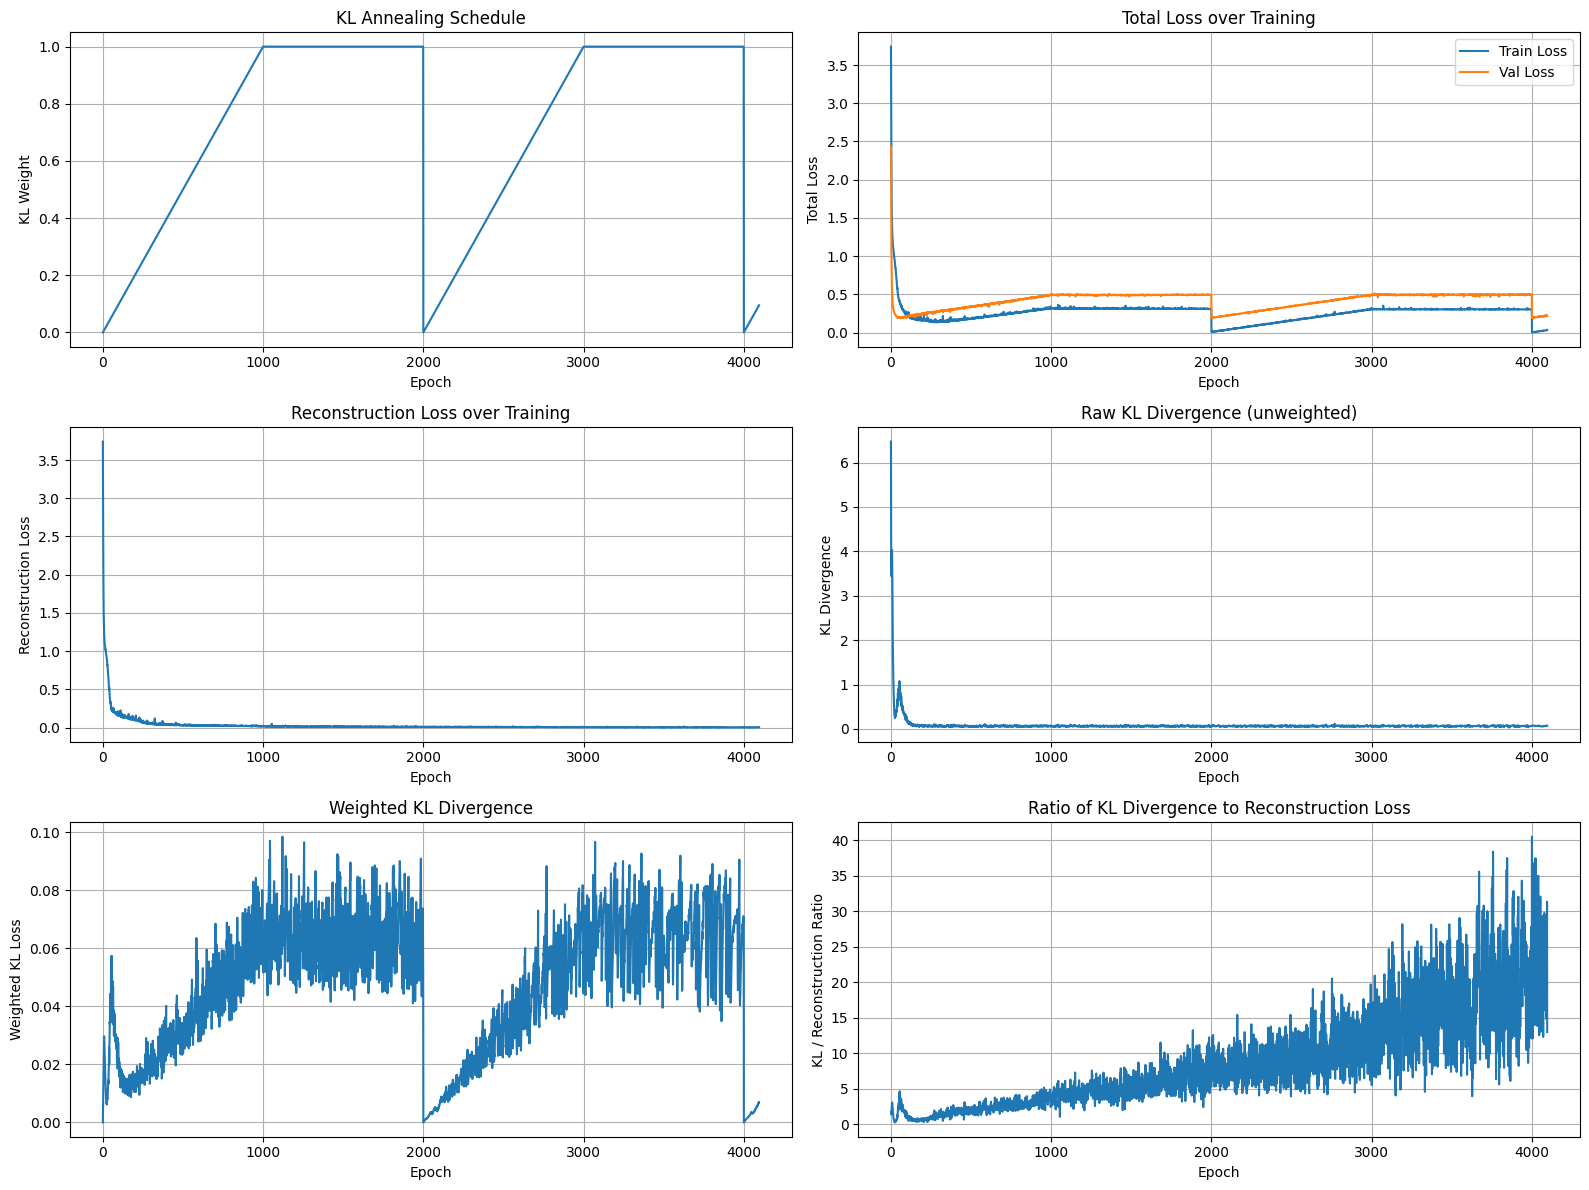

In [15]:
plt.figure(figsize=(16, 12))

# Plot 1: KL weight over time
plt.subplot(3, 2, 1)
plt.plot(kl_weights)
plt.xlabel('Epoch')
plt.ylabel('KL Weight')
plt.title('KL Annealing Schedule')
plt.grid(True)

# Plot 2: Total losses over time
plt.subplot(3, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Total Loss over Training')
plt.legend()
plt.grid(True)

# Plot 3: Reconstruction loss over time
plt.subplot(3, 2, 3)
plt.plot(recon_losses)
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Loss')
plt.title('Reconstruction Loss over Training')
plt.grid(True)

# Plot 4: Raw KL divergence over time
plt.subplot(3, 2, 4)
plt.plot(kl_losses)
plt.xlabel('Epoch')
plt.ylabel('KL Divergence')
plt.title('Raw KL Divergence (unweighted)')
plt.grid(True)

# Plot 5: Weighted KL divergence over time
plt.subplot(3, 2, 5)
plt.plot(weighted_kl_losses)
plt.xlabel('Epoch')
plt.ylabel('Weighted KL Loss')
plt.title('Weighted KL Divergence')
plt.grid(True)

# Plot 6: Ratio of KL to reconstruction loss
plt.subplot(3, 2, 6)
ratio = [kl/recon if recon > 0 else 0 for kl, recon in zip(kl_losses, recon_losses)]
plt.plot(ratio)
plt.xlabel('Epoch')
plt.ylabel('KL / Reconstruction Ratio')
plt.title('Ratio of KL Divergence to Reconstruction Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

In [16]:
def visualize_latent_space(model, data_loader, device, n_samples=1000):
    model.eval()
    latent_vectors = []
    labels = []  # Optional: store conditions or targets for coloring
    
    with torch.no_grad():
        for i, (batch_cond, batch_target) in enumerate(data_loader):
            if len(latent_vectors) * batch_cond.size(0) >= n_samples:
                break
                
            batch_cond = batch_cond.to(device)
            batch_target = batch_target.to(device)
            batch_cond_flat = batch_cond.view(batch_cond.size(0), -1)
            
            # Extract mean vectors from encoder
            mu, _ = model.encoder(batch_cond_flat, batch_target)
            latent_vectors.append(mu.cpu().numpy())
            
            # Optional: store some value for coloring points
            labels.append(batch_target.cpu().numpy())
    
    # Concatenate all batches
    latent_vectors = np.concatenate(latent_vectors, axis=0)[:n_samples]
    labels = np.concatenate(labels, axis=0)[:n_samples]
    
    # Apply dimensionality reduction if latent_dim > 2
    if latent_vectors.shape[1] > 2:
        from sklearn.manifold import TSNE
        from sklearn.decomposition import PCA
        
        # PCA first for stability
        if latent_vectors.shape[1] > 50:
            pca = PCA(n_components=50)
            latent_vectors = pca.fit_transform(latent_vectors)
            
        # t-SNE for final visualization
        tsne = TSNE(n_components=2, random_state=42)
        latent_vectors_2d = tsne.fit_transform(latent_vectors)
    else:
        latent_vectors_2d = latent_vectors
    
    # Plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latent_vectors_2d[:, 0], latent_vectors_2d[:, 1], 
               c=labels[:, 0], cmap='viridis', alpha=0.6)
    plt.colorbar(scatter, label='Target value')
    plt.title('Latent Space Visualization')
    plt.tight_layout()
    plt.show()
    
    # Optional: Also show histogram of each latent dimension
    plt.figure(figsize=(12, 8))
    n_dims = min(latent_vectors.shape[1], 16)  # Show up to 16 dimensions
    rows = int(np.ceil(n_dims / 4))
    for i in range(n_dims):
        plt.subplot(rows, 4, i+1)
        plt.hist(latent_vectors[:, i], bins=30)
        plt.title(f'Dim {i+1}')
    plt.tight_layout()
    plt.show()

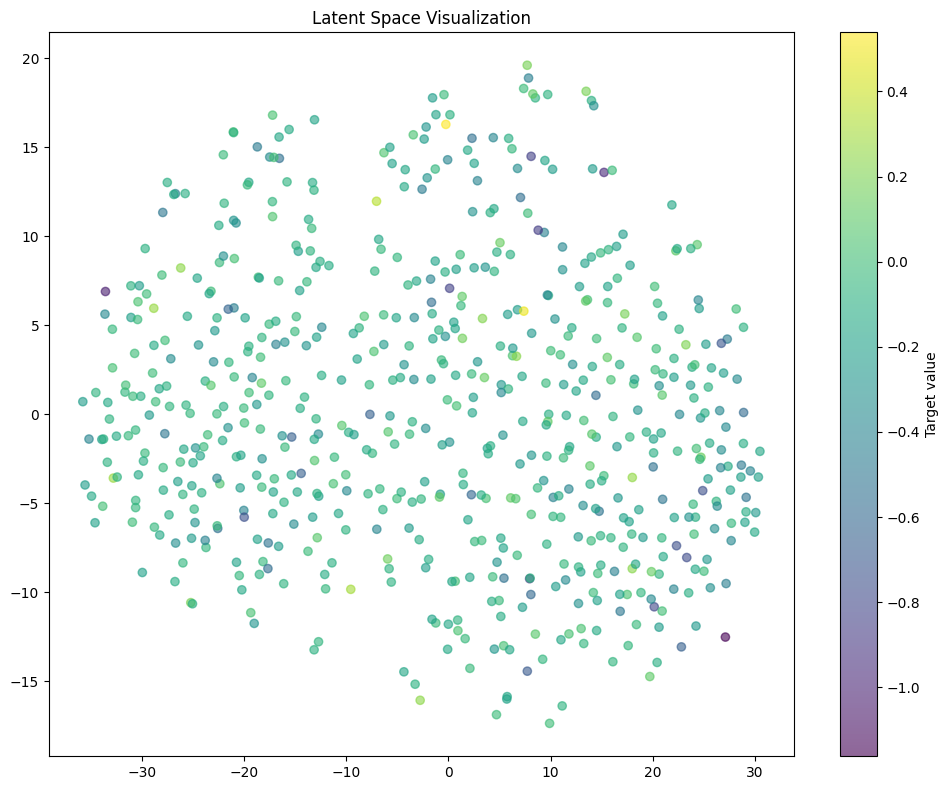

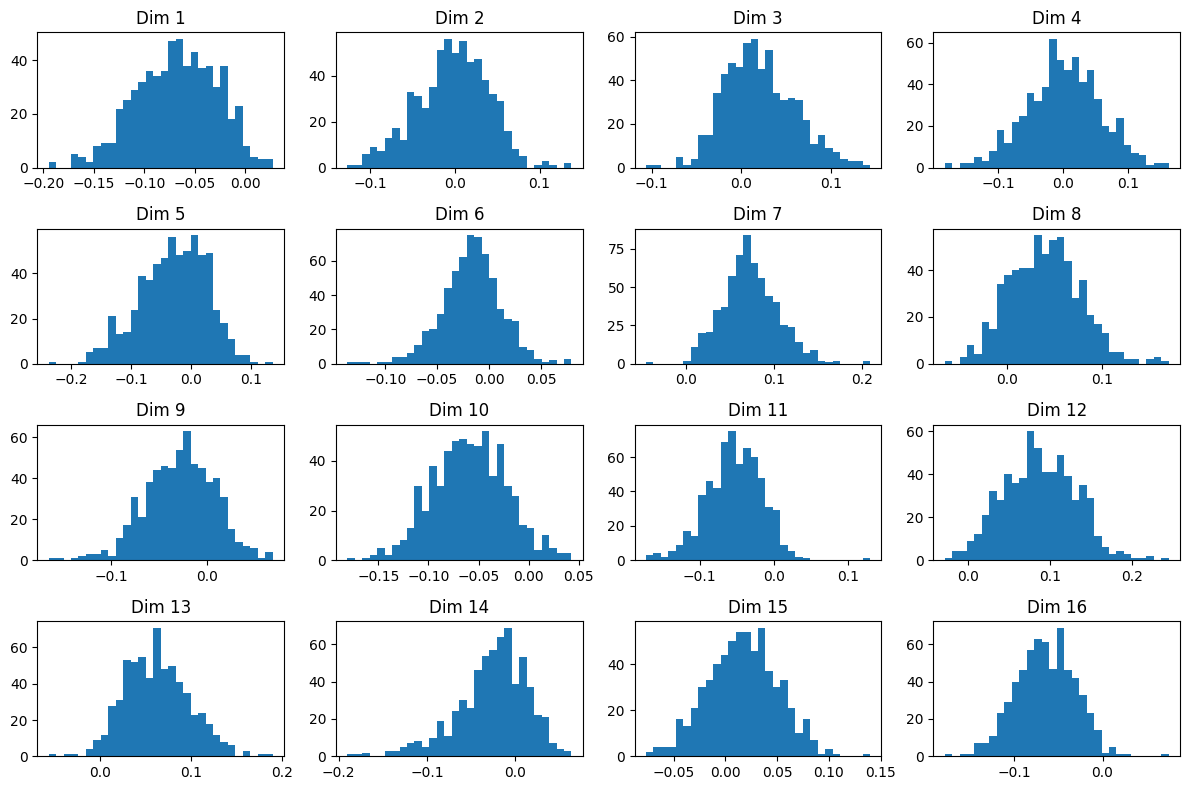

In [23]:
visualize_latent_space(model, train_loader, device)

In [15]:
def evaluate_pinball(model, data_loader, device, quantiles=[0.1, 0.5, 0.9], num_samples=100):
    model.eval()
    results = {q: 0.0 for q in quantiles}
    
    with torch.no_grad():
        for batch_cond, batch_target in data_loader:
            batch_cond = batch_cond.to(device)
            batch_target = batch_target.to(device)
            batch_cond_flat = batch_cond.view(batch_cond.size(0), -1)
            
            # Generate samples from prior
            samples = []
            batch_size = batch_cond.size(0)
            
            for _ in range(num_samples):
                # Sample from prior directly
                z = torch.randn(batch_size, latent_dim, device=device)
                pred = model.decoder(batch_cond_flat, z)
                samples.append(pred.unsqueeze(0))
                
            all_samples = torch.cat(samples, dim=0)
            
            # Evaluate each quantile
            for q in quantiles:
                q_pred = torch.quantile(all_samples, q, dim=0)
                loss = pinball_loss(batch_target, q_pred, q)
                results[q] += loss.item() * batch_size
    
    # Normalize
    for q in quantiles:
        results[q] /= len(data_loader.dataset)
        
    return results

In [16]:
def evaluate_crps(model, data_loader, device, num_samples=100):
    model.eval()
    total_crps = 0.0
    
    with torch.no_grad():
        for batch_cond, batch_target in data_loader:
            batch_cond = batch_cond.to(device)
            batch_target = batch_target.to(device)
            batch_cond_flat = batch_cond.view(batch_cond.size(0), -1)
            
            # Generate samples from prior
            samples = []
            batch_size = batch_cond.size(0)
            
            for _ in range(num_samples):
                # Sample from prior N(0,1) directly 
                z = torch.randn(batch_size, latent_dim, device=device)
                # Generate prediction from sampled latent
                pred = model.decoder(batch_cond_flat, z)
                samples.append(pred.unsqueeze(0))
                
            # Concatenate samples: shape becomes [num_samples, batch, target_dim]
            samples = torch.cat(samples, dim=0)
            
            # Compute CRPS
            batch_crps = crps_loss(batch_target, samples)
            total_crps += batch_crps.item() * batch_size
    
    return total_crps / len(data_loader.dataset)

In [20]:
print(f"CRPS: {evaluate_crps(model, train_loader, device)} - Pinball: {evaluate_pinball(model, train_loader, device)}")

CRPS: 0.06732424534857273 - Pinball: {0.1: 0.009415741194970906, 0.5: 0.03517630393616855, 0.9: 0.05608369945548475}


In [21]:
model.eval()
with torch.no_grad():
    sample_cond, sample_target = next(iter(val_loader))
    sample_cond_flat = sample_cond.view(sample_cond.size(0), -1).to(device)
    sample_target = sample_target.to(device)
    
    mu, logvar = model.encoder(sample_cond_flat, sample_target)
    recon_target = model.decoder(sample_cond_flat, mu)
    
    print("\nValidation Samples and Predictions (First 5):")
    for i in range(5):
        print(f"\nSample {i+1} True Imbalance:")
        print(sample_target[i])
        print(f"Sample {i+1} Predicted Imbalance:")
        print(recon_target[i])



Validation Samples and Predictions (First 5):

Sample 1 True Imbalance:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Sample 1 Predicted Imbalance:
tensor([ 0.0245,  0.0064,  0.0079, -0.0022, -0.0017,  0.0390,  0.0234,  0.0179,
        -0.0014, -0.0206,  0.0295,  0.0169, -0.0240, -0.0098,  0.0068, -0.0083,
         0.0061, -0.0103, -0.0174, -0.0035, -0.0266,  0.0087,  0.0331,  0.0052])

Sample 2 True Imbalance:
tensor([0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100])
Sample 2 Predicted Imbalance:
tensor([ 0.0112, -0.0189, -0.0160,  0.0195,  0.0082,  0.0343,  0.0604,  0.0460,
         0.0389,  0.0037,  0.0478,  0.0309, -0.0054,  0.0112, -0.0016,  0.0340,
         0.0416,  0.0424,  0.0104,  0.0158, -0.0083, -0.0292,  0.0094,  0.0074])

Sample 3 True Imbalance:
tensor([0.,

In [22]:
num_samples = 16
samples = []
sample_cond, sample_target = next(iter(val_loader))
sample_cond_flat = sample_cond.view(sample_cond.size(0), -1).to(device)
sample_target = sample_target.to(device)

model.eval()
with torch.no_grad():
    for i in range(num_samples):
        mu, logvar = model.encoder(sample_cond_flat, sample_target)
        z = model.reparameterize(mu, logvar)
        recon_target = model.decoder(sample_cond_flat, z)
        samples.append(recon_target.cpu().numpy())


In [26]:
batch_index = 4
traces = []
traces.append({"y": sample_target.cpu().numpy()[batch_index], "name": "Target"})
for i, sample in enumerate(samples):
    traces.append({"y": sample[batch_index], "name": f"Sample {i}"})

go.Figure(data=traces)

In [17]:
import datetime as dt

num_samples = 100 

# Generate predictions
with torch.no_grad():
    # Process in batches to avoid memory issues
    batch_size = 32
    num_sequences = cond_tensor.shape[0]
    all_predictions = []
    
    for i in range(0, num_sequences, batch_size):
        batch_cond = cond_tensor[i:min(i+batch_size, num_sequences)].to(device)
        batch_cond_flat = batch_cond.view(batch_cond.size(0), -1)
        
        # Generate multiple samples for each condition
        batch_samples = []
        for _ in range(num_samples):
            # Sample from prior N(0, I)
            z = torch.randn(batch_cond.size(0), model.encoder.fc_mu.out_features).to(device)
            # Generate prediction
            pred = model.decoder(batch_cond_flat, z)
            batch_samples.append(pred.unsqueeze(1))
            
        # Combine all samples: (batch_size, num_samples, target_dim)
        batch_predictions = torch.cat(batch_samples, dim=1)
        all_predictions.append(batch_predictions.cpu())
    
    # Combine all batches
    predictions = torch.cat(all_predictions, dim=0).numpy()

num_sequences = predictions.shape[0]
target_dim = predictions.shape[2] 

# Initialize arrays to store the separate percentiles
up = np.zeros((num_sequences, target_dim))
down = np.zeros((num_sequences, target_dim)) 

# Iterate through each sequence and each target dimension (hour)
for i in range(num_sequences):
    for j in range(target_dim):
        # Get all samples for this specific sequence and hour
        samples = predictions[i, :, j] 
        
        # Separate positive and negative samples
        pos_samples = samples[samples > 0]
        neg_samples = samples[samples < 0]
        
        # Calculate 95th percentile for positive samples
        if pos_samples.size > 0:
            up[i, j] = np.percentile(pos_samples, 95)
        else:
            up[i, j] = 0 

        # Calculate 95th percentile for the negative samples
        if neg_samples.size > 0:
            down[i, j] = np.percentile(np.abs(neg_samples), 95)
        else:
            down[i, j] = 0

# Now, structure your output_data using these calculated values
output_data = np.zeros((num_sequences, target_dim, 2))
output_data[:, :, 0] = down
output_data[:, :, 1] = up


# Save all days to a single CSV file
csv_path = "../data/afrr_p95_predictions.csv"

# Create CSV content
header = "Day,Hour,aFRR_DownActivated,aFRR_UpActivated"
rows = []

use_real_dates = True
start_date = dt.datetime(2023, 1, 1)

for day_idx in range(output_data.shape[0]):
    for hour in range(24):
        down_val = output_data[day_idx, hour, 0]
        up_val = output_data[day_idx, hour, 1]
        
        if use_real_dates:
            current_date = start_date + dt.timedelta(days=day_idx)
            date_str = current_date.strftime("%Y-%m-%d")
            rows.append(f"{date_str},{hour},{down_val:.2f},{up_val:.2f}")
        else:
            rows.append(f"{day_idx+1},{hour},{down_val:.2f},{up_val:.2f}")

# Write to CSV
with open(csv_path, 'w') as f:
    f.write(header + "\n")
    f.write("\n".join(rows))

print(f"All predictions saved to single CSV file: {csv_path}")
print(f"Total days: {output_data.shape[0]}")
print(f"Total rows: {len(rows)}")

All predictions saved to single CSV file: ../data/afrr_p95_predictions.csv
Total days: 640
Total rows: 15360
